# Exercise 1: Regression with Stochastic Gradient Descent

## Part 1: Gradient Descent

Implement your own (GD) function for fitting a linear regression model to yesterday’s salary data. Use matrix algebra! You are provided with a helper notebook which contains the relevant formulas und contains the basic structure.

   - Implement standard (vanilla) gradient descent.

   - Investigate the effect of different learning rates.

## Part 2: Stochastic Gradient Descent

- Create an additional function for stochastic gradient descent. Make sure that you shuffle the dataset befor each new run. Why? What happens if you don’t shuffle them?

- Implement a linear regression model with sklearn and compare it’s result with those from your GD functions.

## Bonus: Mini Batch

Generalize your GD function so that it works with batches of arbitrary size between 1 (stochastic GD) and n (vanilla GD). What are advantages of using mini batch GD?

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.utils import shuffle
from typing import Dict, Tuple, Callable

os.chdir('/Users/patrickrs/Documents/GitLab/patrick-steiner/03-Machine-Learning')

In [88]:
plt.rcParams["figure.figsize"] = (12, 6) #Change matplotlib Box Size
plt.rcParams["font.size"] = 14 #Change matplotlib Font Size

Import Data

In [89]:
data = pd.read_csv('Salary_Data.csv')
data.head()

,YearsExperience,Salary
0,1.1,39343.0
1,1.3,46205.0
2,1.5,37731.0
3,2.0,43525.0
4,2.2,39891.0


Let's have a short look at the data first:

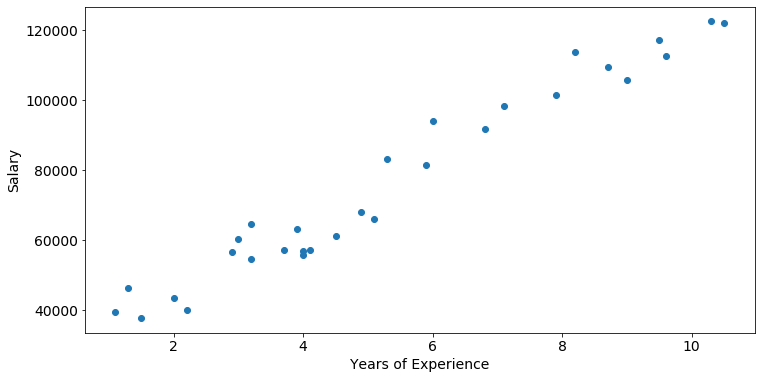

In [90]:
plt.plot(data['YearsExperience'], data['Salary'], 'o')
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
None

## Linear regression - General concept
A linear model assumes that the relationship between the dependent variable y and the our features x is linear and thus takes the form:

$y_i = \beta_{0} + \beta_{1} x_{i1} + \cdots + \beta_{p} x_{ip} + \varepsilon_i,
 \qquad i = 1, \ldots, n$


### Matrix notation

We can simplify the notation by adding a first column with a constant to $X$. In particular,  ${\displaystyle \mathbf {x} _{i0}=1}$ for ${\displaystyle i=1,\ldots ,n}$. The corresponding element $\beta_0$ is called the intercept.

Then the previous formula can be written more compact in matrix notation as:
 
$\mathbf{y} = X\boldsymbol\beta + \boldsymbol\varepsilon$

where

${\displaystyle \mathbf {y} ={\begin{pmatrix}y_{1}\\y_{2}\\\vdots \\y_{n}\end{pmatrix}},\quad }
{\displaystyle X={\begin{pmatrix}\mathbf {x} _{1}^{\mathsf {T}}\\\mathbf {x} _{2}^{\mathsf {T}}\\\vdots \\\mathbf {x} _{n}^{\mathsf {T}}\end{pmatrix}}={\begin{pmatrix}1&x_{11}&\cdots &x_{1p}\\1&x_{21}&\cdots &x_{2p}\\\vdots &\vdots &\ddots &\vdots \\1&x_{n1}&\cdots &x_{np}\end{pmatrix}},}$


${\displaystyle {\boldsymbol {\beta }}={\begin{pmatrix}\beta _{0}\\\beta _{1}\\\beta _{2}\\\vdots \\\beta _{p}\end{pmatrix}},\quad}
{{\boldsymbol {\varepsilon }}={\begin{pmatrix}\varepsilon _{1}\\\varepsilon _{2}\\\vdots \\\varepsilon _{n}\end{pmatrix}}.}$

- $\mathbf {y}$
 is a vector of observed values 
${\displaystyle y_{i}\ (i=1,\ldots ,n)}$
 of the variable called the regressand, endogenous variable or dependent variable. In our case this is the salary.
 
- ${\boldsymbol\displaystyle X}$ is a matrix of row-vectors ${\displaystyle \mathbf {x} _{i}}$ called independent variable and contains the features of our data points. In our case this is the years of experience.

- $\boldsymbol\varepsilon$ is called error term, disturbance term, or sometimes noise. This variable captures all other factors which influence the dependent variable y other than the regressors x.

- $\boldsymbol\beta$ is a vector of the regression coefficients. 
 

 

 
 
 
 
 https://en.wikipedia.org/wiki/Linear_regression

## Extract dependent and independent variables
We create a numpy vector of our independent variable and a numpy array of our independent variable.

Add a column full of ones to $X$ so that ${x} _{i0}=1$  for $i=1,\ldots ,n$. The corresponding element $\beta_0$ is called the intercept or bias.

In [91]:
y = data.iloc[:,1].values.reshape(-1, 1) # reshape to make sure y is a column vector 

X = data.iloc[:,:-1].values
X_b = np.hstack((np.ones((X.shape[0],1)), X))
X_b[:10,:]

array([[1. , 1.1],
       [1. , 1.3],
       [1. , 1.5],
       [1. , 2. ],
       [1. , 2.2],
       [1. , 2.9],
       [1. , 3. ],
       [1. , 3.2],
       [1. , 3.2],
       [1. , 3.7]])

What you mainly need is the formula for calculating the cost function $J(\boldsymbol\theta)$ and its derivative:

$J(\boldsymbol\beta) = \frac{1}{n} (\hat  {\mathbf y} − \mathbf{y})^T (\hat  {\mathbf y} − \mathbf{y}) 
= \frac{1}{n} (X\boldsymbol \beta − \mathbf{y})^T (X\boldsymbol \beta − \mathbf{y})$

$\nabla_\beta J(\boldsymbol\beta) = \frac{2}{n} X^T (X\boldsymbol \beta − \mathbf{y}) = \frac{2}{n} X^T ( \hat  {\mathbf y} − \mathbf{y})$

For a detailed derivation of the gradient in matrix notation check this lecture notes from Stanford:

http://cs229.stanford.edu/notes/cs229-notes1.pdf (chapter 2.2, page 11, they use theta instead of beta)


In [92]:
def predict(X_b: np.ndarray, beta: np.ndarray) -> np.ndarray:
    """
    :param X_b: feature matrix including column of ones for bias
    
    :return: result of the linear regression
    """
    y_hat = np.dot(X_b, beta)
    return y_hat

In [161]:
#  we actually don't need the cost function itself for gradient descent
#  but it is nice to have and certainly a good exercise for you ;)
def calc_cost(X_b: np.ndarray, y: np.ndarray, beta: np.ndarray) -> np.ndarray:
    """
    :param X_b: feature matrix including column of ones for bias
    :param y: labels
    :param beta: regression coefficients 
    :return: return cost
    """
    y_hat = predict(X_b, beta)
    cost = 1/len(y) * np.dot(np.transpose(y_hat - y) , (y_hat - y))
    
    return cost
  

# what we need is the gradient, which consists of the partial derivatives of the cost function
def calc_gradient(
    X_b: np.ndarray, y: np.ndarray, beta: np.ndarray, alpha: float = None
) -> np.ndarray:
    """
    :param X_b: feature matrix including column of ones for bias
    :param y: labels
    :param beta: regression coefficients 
    :param alpha: for Lasso regression (you might need it for exercise 2 - bonus)
    :return: gradient
    """
    y_hat = predict(X_b, beta)
    grad = -2/len(y) * np.dot(np.transpose(X_b), (y - y_hat))
    
    return grad


def update_beta(beta: np.ndarray, gradient: np.ndarray, learning_rate: float = 0.1):
    """
    :param beta: regression coefficient vector
    :param gradient: gradient vector
    :param lr: learning rate for updating beta
    :return: updated beta vector
    """
    beta_new = beta - learning_rate * gradient
    
    return beta_new


def calc_rmse(y: np.ndarray, y_hat: np.ndarray):
    """
    :param y: vector of observed values
    :param y_hat: vector of estimated (predicted) values
    :return: root mean squared error (RMSE)
    """
    rmse = np.sqrt(1/len(y) * np.dot(np.transpose(y - y_hat), (y - y_hat)))
    
    return rmse

In [181]:
y2 = np.array([1, 2, 3])
y_hat2 = np.array([1.3, 2.1, 3.1])
rmse = np.sqrt(1/len(y2) * np.dot(np.transpose(y2 - y_hat2), (y2 - y_hat2)))
type(rmse)

numpy.float64

Let's play a bit with beta to see what effect it has on our linear model:

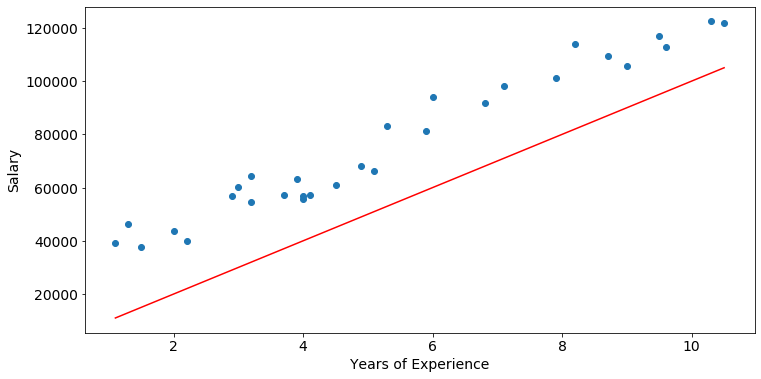

In [94]:
#  try different values and please keep in mind, that for the further calculations beta should be a column vector
beta = np.array([[0], [10000]])

plt.plot(X_b[:,1], y, 'o')
plt.plot(X_b[:,1], predict(X_b, beta), c = 'red')
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
None

# Gradient Decent

This function takes care of running multiple iterations, plotting and collecting the results. Understand what it is exactly doing.

In [211]:
def run_gradient_descent(
    gradient_descent_func: Callable,
    X_b: np.ndarray,
    y: np.ndarray,
    learning_rate: np.ndarray = 0.01,
    epochs: float = 100,
    beta: np.ndarray = None,
    verbose: bool = True,
    create_plot: bool = True,
    step_width_output: int = 100,
    **kwargs,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    :param X_b: feature matrix including column of ones for bias
    :param y: independent variable
    :param learning_rate: learning rate for gradient descent
    :param epochs: number of iterations
    :param beta: regression coefficients 
    :param verbose: print intermediate results
    :**kwargs: additional arguments for the gradient descent function
    :return: 
        - beta_all - numpy array containing regression coefficients of all gradient descent steps
        - rmse_all - numpy array containing RMSE values of all gradient descent steps
    """
    # set missing parameters to default values
    if not beta:
        # Creates random start values for beta
        beta = np.random.rand(X_b.shape[1],1)        
    
    if not (X_b.shape[1] == len(beta)):
        raise ValueError('Check the shape of variables beta and X_b')
        
    if not (X_b.shape[0] == y.shape[0]):
        raise ValueError('Check the shape of variables X_b and y')
       
        
    # initialze arrays for storing intermediate results
    # for large arrays this is computational way more efficient than appending
    rmse_all = np.zeros(epochs + 1)  # vector for saving RMSE values
    rmse_all[0] = calc_rmse(y, predict(X_b, beta))  # insert current value
    beta_all = np.zeros((epochs + 1, len(beta)))  # array for storing beta vectors
    beta_all[0, :] = beta.T  #  insert current values
    
    if verbose:
        print("Epoch: {:4d}, RMSE: {:8.3f}, beta: {}".format(0, rmse_all[0], beta.T))
    if create_plot:
        fig, axs = plt.subplots(1, 3, figsize=(32, 6))
        axs[0].plot(X_b[:, 1], y, "b.")
    else:
        axs = None

    # main loop for iterative gradient descent
    for epoch in range(epochs):
        # call gradient descent function
        beta, y_hat, rmse = gradient_descent_func(X_b, y, beta, learning_rate, **kwargs)
        #print(rmse + epoch)
        type(rmse)
        # add new values to arrays
        beta_all[epoch + 1, :] = beta.T  # Add new beta vector to array
        rmse_all[epoch + 1] = rmse  # Add new RMSE to vector
        
        if verbose and (epoch+1)%step_width_output==0:
            print(
                "Epoch: {:4d}, RMSE: {}, beta: {}".format(epoch + 1, rmse, np.transpose(beta))
            )
        if create_plot and (epoch+1)%step_width_output==0:
            axs[0].plot(X_b[:, 1], y_hat, "r-", alpha=epoch / epochs)

    if verbose:
        print("")
    if create_plot:
        axs[1].plot(rmse_all, label="training loss")
        axs[1].legend(loc="best")
        axs[1].set_ylabel("RMSE")
        axs[1].set_xlabel("Epoch")
        axs[1].grid()
        axs[2].scatter(beta_all[:, 0], beta_all[:, 1], c=range(beta_all.shape[0]))
        axs[2].set_xlabel(r"$\beta_0$")
        axs[2].set_ylabel(r"$\beta_1$")

    return beta_all, rmse_all, axs

In [212]:
def gradient_descent(
    X_b: np.ndarray,
    y: np.ndarray,
    beta: np.ndarray = None,
    learning_rate: np.ndarray = 0.01,
    alpha=None,
):
    """
    :param X_b: feature matrix including column of ones for bias
    :param y: independent variable
    :param learning_rate: learning rate for gradient descent
    :param beta: regression coefficients 
    :param alpha: used for Lasso regression in exercise 2
    :return: 
        - beta - updated regression coefficients
        - y_hat - estimated y
        - rmse - Root mean squared errors
    """
    y_hat = predict(X_b, beta)
    grad = calc_gradient(X_b, y, beta, alpha)
    beta = update_beta(beta, grad, learning_rate)
    rmse = calc_rmse(y, y_hat)
    
    
    return beta, y_hat, rmse

Epoch:    0, RMSE: 80635.268, beta: [[0.50861375 0.87085016]]
Epoch:  100, RMSE: [[9189.75043848]], beta: [[10174.18209878 11767.61082143]]
Epoch:  200, RMSE: [[7351.81272512]], beta: [[15570.82922573 10966.77098127]]
Epoch:  300, RMSE: [[6405.25309151]], beta: [[19102.71988829 10442.65319348]]
Epoch:  400, RMSE: [[5953.96997903]], beta: [[21414.2016952  10099.63897054]]
Epoch:  500, RMSE: [[5749.85307923]], beta: [[22926.97449994  9875.14981966]]
Epoch:  600, RMSE: [[5660.17496713]], beta: [[23917.02406553  9728.23060904]]
Epoch:  700, RMSE: [[5621.32660453]], beta: [[24564.97208472  9632.07783568]]
Epoch:  800, RMSE: [[5604.60477848]], beta: [[24989.02826348  9569.1496741 ]]
Epoch:  900, RMSE: [[5597.42723663]], beta: [[25266.55614754  9527.96569799]]
Epoch: 1000, RMSE: [[5594.35014848]], beta: [[25448.18709714  9501.01242548]]
Epoch: 1100, RMSE: [[5593.031658]], beta: [[25567.05732152  9483.37258185]]
Epoch: 1200, RMSE: [[5592.46682953]], beta: [[25644.85315025  9471.82800656]]
Epoc

(4000, 10000)

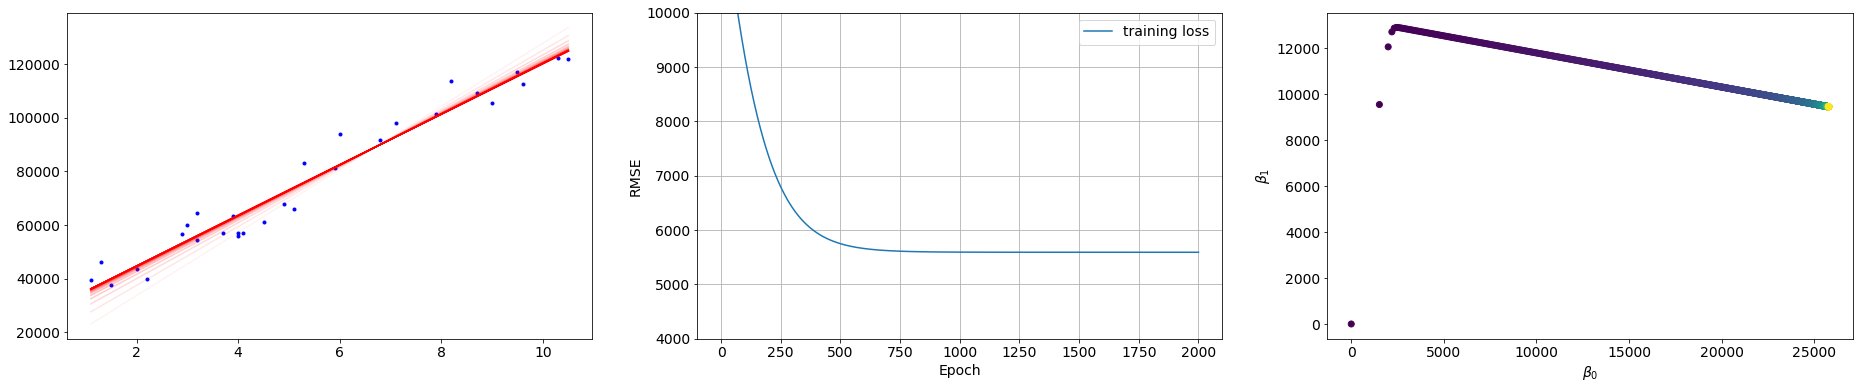

In [213]:
learning_rate = 0.01
epochs = 2000

beta_all, rmse_all, axs = run_gradient_descent(
    gradient_descent, X_b, y, learning_rate, epochs, verbose=True
)
axs[1].set_ylim((4000, 10000))

In [ ]:
### Try different learning rates
learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
epochs = 2000


# Stochastic Gradient Descent

In [12]:
# shuffling points before each iteration, then selecting first N points 
# This obtains a less biased estimation of the true gradient.
# https://www.quora.com/Why-do-we-need-to-shuffle-inputs-for-stochastic-gradient-descent

In [220]:
def stochastic_gradient_descent(
    X_b: np.ndarray,
    y: np.ndarray,
    beta: np.ndarray = None,
    learning_rate: np.ndarray = 0.01,
    shuffle_values: bool = True,
    alpha=None,
):
    """
    :param X_b: feature matrix including column of ones for bias
    :param y: independent variable
    :param learning_rate: learning rate for gradient descent
    :param beta: regression coefficients
    :param shuffle_values: shuffle X_b and y
    :param alpha: used for Lasso regression in exercise 2
    :return: 
        - beta - updated regression coefficients
        - y_hat - estimated y
        - rmse - Root mean squared errors
    """
    # gradient descent
    if shuffle_values:
        X_shuffled, y_shuffled = shuffle(X_b, y)
    else:
        X_shuffled, y_shuffled = X_b, y

    for ind_point in range(X_b.shape[0]):
        y_hat = predict(X_b, beta)
        grad = calc_gradient(X_b[ind_point:ind_point + 1], y[ind_point:ind_point + 1], beta, alpha)
        beta = update_beta(beta, grad, learning_rate)
        rmse = calc_rmse(y, y_hat)
    
    return beta, y_hat, rmse

In [236]:
int(2.9)

2

Epoch:    0, RMSE: 80635.323, beta: [[0.18204364 0.91367533]]
Epoch:  100, RMSE: [[6392.40216933]], beta: [[19502.51339941 10103.83463161]]
Epoch:  200, RMSE: [[5631.96515837]], beta: [[24483.54507935  9523.85492165]]
Epoch:  300, RMSE: [[5592.85056559]], beta: [[25925.4835467   9355.95897001]]
Epoch:  400, RMSE: [[5598.02710136]], beta: [[26342.90440994  9307.35545838]]
Epoch:  500, RMSE: [[5600.90914374]], beta: [[26463.7418666   9293.28542679]]
Epoch:  600, RMSE: [[5601.85916056]], beta: [[26498.72260719  9289.21235095]]
Epoch:  700, RMSE: [[5602.14386599]], beta: [[26508.84903856  9288.0332529 ]]
Epoch:  800, RMSE: [[5602.22709596]], beta: [[26511.78049772  9287.69192064]]
Epoch:  900, RMSE: [[5602.25125789]], beta: [[26512.62911383  9287.59310976]]
Epoch: 1000, RMSE: [[5602.25825813]], beta: [[26512.87477623  9287.5645054 ]]
Epoch: 1100, RMSE: [[5602.26028508]], beta: [[26512.94589204  9287.55622484]]
Epoch: 1200, RMSE: [[5602.26087189]], beta: [[26512.96647906  9287.55382774]]
Ep

(4000, 10000)

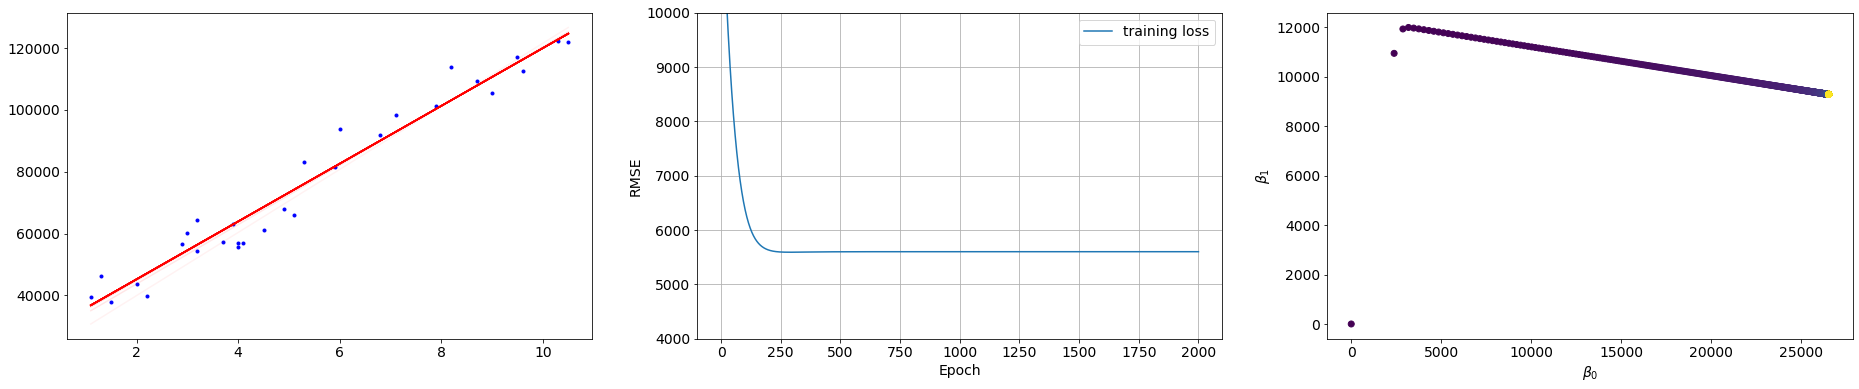

In [232]:
learning_rate = .001
epochs = 2000
beta_all, rmse_all, axs = run_gradient_descent(
    stochastic_gradient_descent, X_b, y, learning_rate, epochs, verbose=True
)
axs[1].set_ylim((4000, 10000))

# Mini Batch

In [237]:
def mini_batch_gradient_descent(X_b, y, beta, learning_rate, shuffle_values=True, batch_size=None, alpha=None):
    """
    :param X_b: feature matrix including column of ones for bias
    :param y: independent variable
    :param learning_rate: learning rate for gradient descent
    :param beta: regression coefficients
    :param shuffle_values: shuffle X_b and y
    :param batch_size: number of elements per batch
    :param alpha: used for Lasso regression in exercise 2
    :return: 
        - beta - updated regression coefficients
        - y_hat - estimated y
        - rmse - Root mean squared errors
    """
     
    # mini batch gradient descent
    
    if shuffle_values:
        X_shuffled, y_shuffled = shuffle(X_b, y)
    else:
        X_shuffled, y_shuffled = X_b, y

    for ind_point in range(int(X_b.shape[0]/batch_size)):
        y_hat = predict(X_b, beta)
        grad = calc_gradient(X_b[ind_point:ind_point + 1], y[ind_point:ind_point + 1], beta, alpha)
        beta = update_beta(beta, grad, learning_rate)
        rmse = calc_rmse(y, y_hat)
    
    return beta, y_hat, rmse
        
    return beta, y_hat, rmse


Epoch:    0, RMSE: 80638.124, beta: [[0.01247922 0.46745563]]
Epoch:  100, RMSE: [[8081.55104252]], beta: [[13394.67955276 11035.54256118]]
Epoch:  200, RMSE: [[6352.67355265]], beta: [[19381.68993475 10255.49925698]]
Epoch:  300, RMSE: [[5794.79791324]], beta: [[22555.08657102  9842.03967703]]
Epoch:  400, RMSE: [[5639.14458949]], beta: [[24237.13580237  9622.88668471]]
Epoch:  500, RMSE: [[5600.51517042]], beta: [[25128.70087946  9506.72530795]]
Epoch:  600, RMSE: [[5592.73473717]], beta: [[25601.27223581  9445.15432365]]
Epoch:  700, RMSE: [[5592.20084687]], beta: [[25851.75724535  9412.51881076]]
Epoch:  800, RMSE: [[5592.92734782]], beta: [[25984.5260625   9395.22045645]]
Epoch:  900, RMSE: [[5593.59595806]], beta: [[26054.89977005  9386.05151638]]
Epoch: 1000, RMSE: [[5594.02998146]], beta: [[26092.20113962  9381.1915476 ]]
Epoch: 1100, RMSE: [[5594.2824002]], beta: [[26111.97261706  9378.61553593]]
Epoch: 1200, RMSE: [[5594.42247675]], beta: [[26122.45242852  9377.25012879]]
Epo

(4000, 10000)

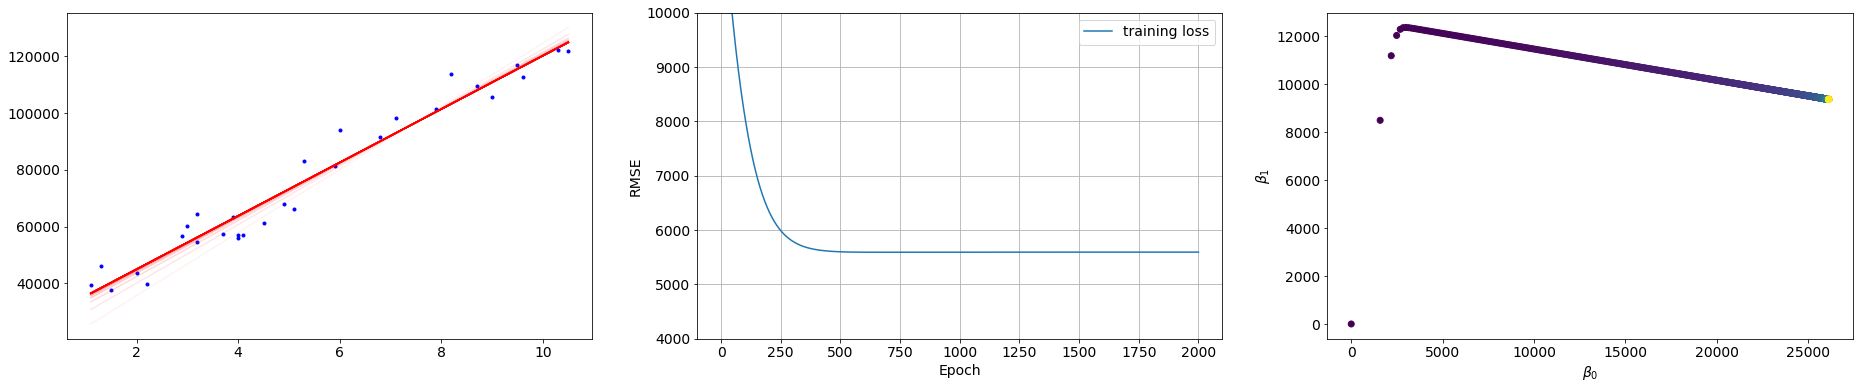

In [241]:
learning_rate = 0.0005
epochs = 2000

beta_all, rmse_all, axs = run_gradient_descent(
    mini_batch_gradient_descent,
    X_b,
    y,
    learning_rate,
    epochs,
    batch_size=1,
    shuffle_values=True,
    verbose=True,
    create_plot=True,
)

axs[1].set_ylim((4000, 10000))

# Sklearn

Compare your results with the solver from sklearn.

In [245]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error


In [270]:
X = X_b[:,1].reshape(-1, 1)
regr = linear_model.LinearRegression()
regr.fit(X = X, y = y)
y_hat = regr.predict(X = X)
# Print the coefficients
print('Coefficients: ', [regr.intercept_[0], regr.coef_[0,0]])
# The root mean squared error
print("RMSE: %.2f"
      % np.sqrt(mean_squared_error(y, y_hat)))

Coefficients:  [25792.20019866871, 9449.962321455074]
RMSE: 5592.04


# Part 2: Lasso and Ridge
Perform Lasso and Ridge regression on yesterday’s wine dataset. Visualize the effect of different alpha values on the coefficients (Hint: The logarithm is your friend!).
- Compare the values of coefficients obtained by these two methods with the multiple linear regression coefficients. Use visuals wherever necessary!

In [313]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline

In [277]:
wine =  pd.read_csv('winequality-white.csv', sep = ";")

In [278]:
X = wine.drop(['alcohol'], axis = 1)
y = wine['alcohol']

In [314]:
lreg = linear_model.Lasso(alpha = .5)
lreg.fit(X = X, y = y)
y_hat = lreg.predict(X = X)
print(lreg.coef_)
print('Coefficients: ', [lreg.intercept_, lreg.coef_])
# The root mean squared error
print("RMSE: %.2f"
      % np.sqrt(mean_squared_error(y, y_hat)))

[-0.          0.         -0.         -0.05635803 -0.          0.00098692
 -0.01026464 -0.          0.          0.          0.        ]
Coefficients:  [12.259850563052009, array([-0.        ,  0.        , -0.        , -0.05635803, -0.        ,
        0.00098692, -0.01026464, -0.        ,  0.        ,  0.        ,
        0.        ])]
RMSE: 1.04


In [288]:
rreg = linear_model.Ridge(alpha = 0.5)
rreg.fit(X = X, y = y)
y_hat = rreg.predict(X = X)
print('Coefficients: ', [rreg.intercept_, rreg.coef_])
# The root mean squared error
print("RMSE: %.2f"
      % np.sqrt(mean_squared_error(y, y_hat)))

Coefficients:  [16.719202863837616, array([-3.04663878e-02,  2.45581492e+00,  4.78444851e-01, -7.30862236e-02,
       -1.03741314e+01,  2.81015484e-03, -7.65795090e-03, -8.24303986e+00,
        1.31433662e-01, -5.39442695e-02,  4.87282237e-01])]
RMSE: 0.86


In [315]:
hold = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = hold)
sc = StandardScaler()
model = linear_model.LinearRegression()
pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_test)
model_score = pipeline.score(X_test, y_test)

In [296]:
alphas = np.arange(0.01, 1, 0.01)
coefs = np.empty(shape = [len(alphas) , X.shape[1]])

for alpha in alphas:
    pipeline = Pipeline([('data_scaling', sc), ('estimator', model)])
    
    

In [303]:
X.shape[1]

11

In [306]:
coefs = np.empty(shape = [len(alphas) , X.shape[1]])

In [309]:
coefs.shape

(99, 11)